# Optimising Demand Response Strategies for Carbon Intelligent Load Shifting

# Processing ERA5 Land Data

**NOTEBOOK PURPOSE(S):**
* Process ERA5 land data downloaded from the hitachi database

**LIMITATIONS:**
* This notebook is designed to work with the ERA5 land data downloaded from the hitachi database
* It assumes the data is in the correct format and contains the necessary columns for processing

**NOTEBOOK INPUT** 
* weather_20250714_1401.parquet


**NOTEBOOK OUTPUTS:**
* Primary output:
    * weather_20250714_1401_processed.parquet
* Intermediate outputs:
    * weather_20250714_1401_step1.parquet
    * weather_20250714_1401_step2.parquet
    * weather_20250714_1401_step3.parquet
    * weather_20250714_1401_step4.parquet
    * (note that these are deleted at the end of the notebook)

    

### Importing Libraries

In [1]:
%matplotlib inline

# ────────────────────────────────────────────────────────────────────────────
# Data Manipulation & Analysis
# ─────────────────────────────────────────────────────────────────────────────
import pandas as pd
import polars as pl
from functools import reduce
from typing import List


# ─────────────────────────────────────────────────────────────────────────────
# Geospatial Data Handling
# ─────────────────────────────────────────────────────────────────────────────
from shapely.wkb import loads

# ─────────────────────────────────────────────────────────────────────────────
# Visualization
# ─────────────────────────────────────────────────────────────────────────────
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# ─────────────────────────────────────────────────────────────────────────────
# Notebook/Display Tools
# ─────────────────────────────────────────────────────────────────────────────
from IPython.display import display

# ─────────────────────────────────────────────────────────────────────────────
# System / Miscellaneous
# ─────────────────────────────────────────────────────────────────────────────#
import os
import calendar
import binascii
import re
from datetime import date
from zoneinfo import ZoneInfo
from typing import Optional, Union

## Loading Data from Local Storage

In [2]:
cwd = os.getcwd()
print("-"*120)
print("Current Working Directory and contents:\n"+"-"*120)
for root, dirs, files in os.walk(cwd):
    print(f"\nDirectory: {root}")
    print(f"Subdirectories: {dirs}\n"+ "-"*40)
    for file in sorted(files):
        print(f"-> File: {file}")


------------------------------------------------------------------------------------------------------------------------
Current Working Directory and contents:
------------------------------------------------------------------------------------------------------------------------

Directory: /Users/Daniel/Desktop/IRP_WORK_UPDATED.nosync/new_repo/MSc-Thesis-OptimisingDemandResponseStrategiesForCarbonIntelligentElectricityUse/code_and_analysis/jupyter_notebooks
Subdirectories: []
----------------------------------------
-> File: .DS_Store
-> File: marginal_emissions_data_prep.ipynb
-> File: marginal_emissions_model_development.ipynb
-> File: step1_hitachi_data_retrieval.ipynb
-> File: step2_initial_data_analysis.ipynb
-> File: step2_investigating_data_size_and_types.ipynb
-> File: step2_investigating_era5_world_data.ipynb
-> File: step3_combining_era5_datasets.ipynb
-> File: step3_combining_grid_and_weather_data.ipynb
-> File: step3_processing_era5_land_data.ipynb
-> File: step3_process

### Defining File Paths

In [6]:
# Reminder of data directory structure and contents
root_directory = os.path.join('..', '..')
base_data_directory = os.path.join(root_directory, "data")
hitachi_data_directory = os.path.join(base_data_directory, 'hitachi')


In [7]:
print("-"*120)
print("[hitachi_data_directory] and contents:\n"+"-"*120)
for root, dirs, files in os.walk(hitachi_data_directory):
    print(f"\nDirectory: {root}")
    print(f"Subdirectories: {dirs}\n"+ "-"*40)
    for file in sorted(files):
        print(f"-> File: {file}")


------------------------------------------------------------------------------------------------------------------------
[hitachi_data_directory] and contents:
------------------------------------------------------------------------------------------------------------------------

Directory: ../../data/hitachi
Subdirectories: ['meter_primary_files']
----------------------------------------
-> File: .DS_Store
-> File: customers_20250714_1401.parquet
-> File: grid_readings_20250714_1401.parquet
-> File: grid_readings_20250714_1401_processed.parquet
-> File: grid_readings_20250714_1401_processed_half_hourly.parquet
-> File: meter_readings_20250701_1318.parquet
-> File: weather_20250714_1401.parquet
-> File: weather_20250714_1401_processed.parquet
-> File: weather_and_grid_data_half-hourly_20250714_1401.parquet
-> File: weather_data_combined_20250714_1401.parquet

Directory: ../../data/hitachi/meter_primary_files
Subdirectories: []
----------------------------------------
-> File: .DS_Stor

In [8]:
# ------------------------- Filename & Filepath -------------------------

weather_filename = "weather_20250714_1401"
weather_filepath = os.path.join(hitachi_data_directory, weather_filename + ".parquet")

# we'll also set up a list to store temporary filepaths for different processing steps
weather_processing_filepaths = []

In [9]:
weather_data_pldf = pl.read_parquet(weather_filepath)

## Data Processing

In [10]:
print("\n" + "-" * 120)
print("First few rows of weather data:\n" + "-" * 120)
display(weather_data_pldf.head(5))
print("\n" + "-" * 120)
print("Descriptive statistics of weather data:\n" + "-" * 120)
display(weather_data_pldf.describe())


------------------------------------------------------------------------------------------------------------------------
First few rows of weather data:
------------------------------------------------------------------------------------------------------------------------


timestamp,wind_speed,wind_direction,temperature,city,precipitation,location,surface_net_solar_radiation,surface_solar_radiation_downwards
datetime[μs],"decimal[38,18]","decimal[38,20]","decimal[38,15]",str,"decimal[38,28]",str,"decimal[38,17]","decimal[38,17]"
2024-12-13 13:00:00,8.013575020999754000,105.09231811866465000000,15.975219726562500,"""delhi""",0.0000000000000000000000000000,"""0101000020E6100000F6285C8FC255…",12296608.00000000000000000,14926616.00000000000000000
2024-12-13 14:00:00,8.289883957905610000,110.72614327536141000000,14.646026611328125,"""delhi""",0.0000000000000000000000000000,"""0101000020E6100000F6285C8FC235…",12108108.00000000000000000,14736050.00000000000000000
2024-12-13 14:00:00,8.336890954411203000,110.27725102589554000000,14.629241943359375,"""delhi""",0.0000000000000000000000000000,"""0101000020E61000005C8FC2F5283C…",12149601.00000000000000000,14737817.00000000000000000
2024-12-13 14:00:00,8.403726468287198000,109.70666556656998000000,14.623779296875000,"""delhi""",0.0000000000000000000000000000,"""0101000020E6100000C2F5285C8F42…",12240716.00000000000000000,14738703.00000000000000000
2024-12-13 14:00:00,8.454637190808407000,109.04352821446052000000,14.611297607421875,"""delhi""",0.0000000000000000000000000000,"""0101000020E6100000285C8FC2F548…",12278334.00000000000000000,14740205.00000000000000000



------------------------------------------------------------------------------------------------------------------------
Descriptive statistics of weather data:
------------------------------------------------------------------------------------------------------------------------


statistic,timestamp,wind_speed,wind_direction,temperature,city,precipitation,location,surface_net_solar_radiation,surface_solar_radiation_downwards
str,str,f64,f64,f64,str,f64,str,f64,f64
"""count""","""3989664""",2.046285e6,2.046285e6,2.046285e6,"""3989664""",2.046285e6,"""3989664""",1.889953e6,1.889954e6
"""null_count""","""0""",1.943379e6,1.943379e6,1.943379e6,"""0""",1.943379e6,"""0""",2.099711e6,2.09971e6
"""mean""","""2022-09-15 12:30:00""",5.913636,167.302513,25.379801,null,0.001737,null,1.1276e7,1.3538e7
"""std""",null,3.125727,88.154022,6.977661,null,0.006866,null,6.9285e6,8.3022e6
"""min""","""2019-12-31 01:00:00""",0.005403,0.000265,0.487457,"""delhi""",0.0,"""0101000020E610000014AE47E17A24…",0.0,0.0
"""25%""","""2021-05-08 19:00:00""",3.790591,106.347651,21.677216,null,0.0,null,5.062334e6,6.017553e6
"""50%""","""2022-09-15 13:00:00""",5.431484,145.85406,26.418579,null,0.000001,null,1.2313436e7,1.4862e7
"""75%""","""2024-01-23 06:00:00""",7.45679,241.901807,29.746643,null,0.000466,null,1.6668687e7,1.9912196e7
"""max""","""2025-06-01 00:00:00""",42.517314,359.999979,46.374786,"""mumbai""",0.314005,"""0101000020E6100000F6285C8FC255…",2.49234e7,2.9038414e7


In [11]:
weather_data_pldf.schema

Schema([('timestamp', Datetime(time_unit='us', time_zone=None)),
        ('wind_speed', Decimal(precision=38, scale=18)),
        ('wind_direction', Decimal(precision=38, scale=20)),
        ('temperature', Decimal(precision=38, scale=15)),
        ('city', String),
        ('precipitation', Decimal(precision=38, scale=28)),
        ('location', String),
        ('surface_net_solar_radiation', Decimal(precision=38, scale=17)),
        ('surface_solar_radiation_downwards',
         Decimal(precision=38, scale=17))])

**DATA PROCESSING PLAN**

The following steps will be taken to process the ERA5 land data:
1. Data Preparation
    * Change the data types of the columns to work better with polars
    * Update the timezone

2. Data Transformation (1)
    * calculate radiation in kwh/m^2
    * change precipitation to mm
    * change wind speed to m/s
    * change wind direction from mathematical to meteorological

3. Data Transformation (2)
    * Convert location to latitude and longitude

4. Data Validation
    * Check for missing values
    * Check for duplicate rows

5. Data Transformation (3)
    * Remove Null Locations
    * Filtered out locations with 0% completeness

### Helper Functions

#### Transformation Functions

In [12]:
def wkb_to_coords(hex_wkb: str):
    """
    Convert a hex WKB string to coordinates (x, y).
    Uses binascii to decode the hex string and shapely's load function to convert WKB to a Point object.

    Parameters:
    ----------
    hex_wkb : str
        Hexadecimal string representing the WKB (Well-Known Binary) format of a point.

    Returns:
    -------
    tuple
        A tuple containing the x and y coordinates of the point, or (None, None)
        if the conversion fails.
    """
    try:
        point = loads(binascii.unhexlify(hex_wkb))
        return point.x, point.y
    except Exception:
        return None, None

#### Profiling Functions

In [13]:
def count_isolated_nulls(
        df: pl.DataFrame,
        colname: str,
        grouping_cols: list = ["weather_longitude", "weather_latitude"]
) -> pl.DataFrame:
    """
    Function to count the number of isolated nulls in a specified column of a DataFrame.
    (an isolated null is a null value that has non-null values on both sides of it)

    Parameters:
    ----------
    df : pl.DataFrame
        The DataFrame to process.
    colname : str
        The name of the column to check for isolated nulls.

    Returns:
    -------
    pl.DataFrame
        A DataFrame with the count of isolated nulls per location.
    """
    df = df.sort(grouping_cols + ["timestamp"])

    flagged = (df
               .with_columns([
                    pl.col(colname).is_null().alias("is_null"),
                    # windowed shifts so we only compare within each station
                    pl.col(colname).shift(1).over(grouping_cols).is_null().alias("prev_null"),
                    pl.col(colname).shift(-1).over(grouping_cols).is_null().alias("next_null"),
                    ])
                .with_columns([
                    # isolated if current is null but neither neighbor is
                    (pl.col("is_null") & ~pl.col("prev_null") & ~pl.col("next_null")).alias("is_isolated_null")
                ]))

    # 2) aggregate by station, summing that flag
    return (
        flagged
        .group_by(grouping_cols)
        .agg(
            pl.col("is_isolated_null")
              .sum()
              .cast(pl.UInt32)
              .alias(f"{colname}_isolated_nulls")
        )
    )

In [14]:
def analyze_null_patterns(
        df: pl.DataFrame,
        colname: str,
        grouping_cols: list[str] = ["weather_longitude", "weather_latitude"]
) -> pl.DataFrame:
    """
    Analyze null patterns in a specified column of a DataFrame.

    Parameters:
    ----------
    df : pl.DataFrame
        The DataFrame to analyze.
    colname : str
        The name of the column to analyze for null patterns.
    grouping_cols : list, optional
        List of columns to group by (default is ["weather_longitude", "weather_latitude"]).

    Returns:
    -------
    pl.DataFrame
        A DataFrame containing the following columns:
        - grouping_cols: The columns used for grouping.
        - f"{colname}_total_nulls": Total number of nulls in the specified column.
        - f"{colname}_isolated_nulls": Number of isolated nulls in the specified column.
        - f"{colname}_gaps": List of structs containing start and end timestamps of gaps longer than 1 hour.
    """
    # 0) sort by station + timestamp
    df = df.sort(grouping_cols + ["timestamp"])

    # 1) ensure every station shows up
    all_locs = df.select(grouping_cols).unique()

    # 2) basic null counts & isolated‐nulls

    # flagging the entries that are null, and those that are isolated
    flagged = (
        df
        .with_columns([
            pl.col(colname).is_null().alias("is_null"),
            # windowed shifts so we only compare within each station
            pl.col(colname).shift(1).over(grouping_cols).is_null().alias("previous_is_null"),
            pl.col(colname).shift(-1).over(grouping_cols).is_null().alias("next_is_null"),
        ])
        .with_columns([(
                        pl.col("is_null") &
                        ~pl.col("previous_is_null") &
                        ~pl.col("next_is_null")
                    ).alias("is_isolated_null")])
    )
    basic_stats = (
        flagged
        .group_by(grouping_cols)
        .agg([
            pl.col("is_null")
                .sum()
                .cast(pl.UInt32)
                .alias(f"{colname}_total_nulls"),
            pl.col("is_isolated_null")
                .sum()
                .cast(pl.UInt32)
                .alias(f"{colname}_isolated_nulls"),
        ])
    )

    # 3) flag nulls, then number each run of (null vs non‐null) per station
    runs = (
        flagged
        # first add the boolean flag
        .with_columns(
            pl.col(colname).is_null().alias("is_null")
        )
        # then number runs whenever is_null flips
        .with_columns(
            (
              pl.col("is_null") != pl.col("is_null").shift(1)
            )
            .cum_sum()
            .over(grouping_cols)
            .alias("run_id")
        )
    )

    # 4) extract only the null‐runs, get their start/end timestamps
    #    then drop any shorter than 1h, and finally implode to a list of Structs
    gap_intervals = (
        runs
        .filter(pl.col("is_null"))
        .group_by(grouping_cols + ["run_id"])
        .agg([
            pl.col("timestamp").first().alias("gap_start"),
            pl.col("timestamp").last().alias("gap_end"),
        ])
        .filter(
            (pl.col("gap_end") - pl.col("gap_start")) > pl.duration(hours=1)
        )
        .group_by(grouping_cols)
        .agg(
            pl.struct(["gap_start", "gap_end"])
              .implode()
              .alias(f"{colname}_gaps")
        )
    )

    # 5) stitch it all together, filling missing gaps‐lists with empty lists
    return (
        all_locs
        .join(basic_stats,   on=grouping_cols, how="left")
        .join(gap_intervals, on=grouping_cols, how="left")
        .with_columns(
            pl.col(f"{colname}_gaps").fill_null([])
        )
    )

In [15]:
# Completeness report
def compute_completeness(
        df: pl.DataFrame,
        grouping_col: str,
        columns_to_check: List[str]
) -> pl.DataFrame:
    """
    Compute per‐group completeness counts and ratios for a set of columns.

    Parameters:
    ----------
    df : pl.DataFrame
        The DataFrame to analyze.
    grouping_col : str
        The column to group by (e.g., "location").
    columns_to_check : List[str]
        List of column names to check for completeness.

    Returns:
    -------
    pl.DataFrame
        A DataFrame with completeness statistics for each group.
        generated columns:
        - total_rows: Total number of rows in each group.
        - {col}_non_null: Count of non-null values in each specified column.
        - {col}_completeness: Ratio of non-null values to total rows for each column.
        - avg_completeness: Average completeness across all specified columns.
        - min_completeness: Minimum completeness across all specified columns.
        - max_completeness: Maximum completeness across all specified columns.
    """
    # 1) basic counts
    completeness = df.group_by(grouping_col).agg([
        pl.len().alias("total_rows"),
        *[pl.col(col).is_not_null().sum().alias(f"{col}_non_null")
          for col in columns_to_check]
    ])

    # 2) add ratios
    for col in columns_to_check:
        completeness = completeness.with_columns([
            (pl.col(f"{col}_non_null") / pl.col("total_rows"))
              .alias(f"{col}_completeness")
        ])

    # 3) summary stats across completeness columns
    comp_cols = [f"{col}_completeness" for col in columns_to_check]
    completeness = completeness.with_columns([
        pl.mean_horizontal([pl.col(c) for c in comp_cols])
          .alias("avg_completeness"),
        pl.min_horizontal([pl.col(c) for c in comp_cols])
          .alias("min_completeness"),
        pl.max_horizontal([pl.col(c) for c in comp_cols])
          .alias("max_completeness"),
    ])

    return completeness

In [16]:
def completeness_transform_long(
        completeness_df: pl.DataFrame,
        grouping_col: str,
        columns_to_check: List[str]
) -> pd.DataFrame:
    """
    Take the output of compute_completeness and pivot it into long form
    for plotting (one row per group+variable).

    Parameters:
    ----------
    completeness_df : pl.DataFrame
        The DataFrame containing completeness statistics.
    grouping_col : str
        The column used for grouping (e.g., "location").
    columns_to_check : List[str]
        List of column names to check for completeness.

    Returns:
    -------
    pd.DataFrame
        A Pandas DataFrame in long format with the following columns:
        - grouping_col: The column used for grouping (e.g., "location").
        - column: The name of the column for which completeness is measured.
        - completeness: The completeness ratio (0.0–1.0).
    """
    # Create expected completeness columns
    # Handle string or list for grouping_col
    if isinstance(grouping_col, str):
        group_cols = [grouping_col]
    else:
        group_cols = grouping_col

    # Construct expected completeness column names
    comp_cols = [f"{col}_completeness" for col in columns_to_check]

    # Validate columns exist
    existing_cols = set(completeness_df.columns)
    required_cols = group_cols + comp_cols
    missing_cols = [col for col in required_cols if col not in existing_cols]

    if missing_cols:
        raise KeyError(f"The following required columns are missing from completeness_df: {missing_cols}")

    # Convert to pandas
    pdf = completeness_df.select(required_cols).to_pandas()

    # Melt to long format
    long = pdf.melt(
        id_vars=group_cols,
        value_vars=comp_cols,
        var_name="column",
        value_name="completeness"
    )
    long["completeness_pct"] = long["completeness"] * 100
    return long

In [17]:
# Histogram and count annotation
def hist_with_counts(data, **kwargs) -> None:
    """
    Create a histogram of the 'completeness_pct' column in the provided DataFrame
    and annotate it with the count of occurrences in each bin.

    Parameters:
    ----------
    data : pd.DataFrame
        The DataFrame containing the 'completeness_pct' column to be plotted.
    **kwargs : dict
        Additional keyword arguments to be passed to the matplotlib histogram function.

    Returns:
    -------
    None
        Displays the histogram with counts annotated on top of each bar.
    """
    ax = plt.gca()
    counts, bins, patches = ax.hist(
        data["completeness_pct"], bins=range(0, 101, 2), edgecolor='black', **kwargs
    )
    # Add count labels
    for count, patch in zip(counts, patches):
        if count > 0:
            x = patch.get_x() + patch.get_width() / 2
            ax.text(x, count + 0.5, f"{int(count)}", ha="center", va="bottom", fontsize=8)


### Converting Datatypes

In [18]:
weather_data_type_conversions = (
    pl.scan_parquet(weather_filepath)
    .with_columns(
        # NOTE - converting to specific timezone makes downstream operations more complex,
        # so we will not convert the timestamp to a specific timezone here.
        # Instead, we will keep it as UTC and handle timezone conversion later
        # converting timestamp to datetime with timezone
        # pl.col("timestamp").dt.convert_time_zone("Asia/Kolkata"),
        pl.col("timestamp").dt.convert_time_zone("UTC"),
        # specifying the unit for the windspeed
        pl.col("wind_speed").cast(dtype=pl.Float32).alias("wind_speed_mph"),
        # Flagging that the wind direction was originally calculated in mathematical degrees
        pl.col("wind_direction").cast(dtype=pl.Float32).alias("wind_direction_mathematical"),
        pl.col("temperature").cast(dtype=pl.Float64),
        # specifying the unit for the precipitation
        pl.col("precipitation").cast(dtype=pl.Float64).alias("precipitation_meters"),
        # specifying the unit for the solar radiation
        pl.col("surface_net_solar_radiation").cast(dtype=pl.Float64).alias("surface_net_solar_radiation_joules_per_m2"),
        pl.col("surface_solar_radiation_downwards").cast(dtype=pl.Float64).alias("surface_solar_radiation_downwards_joules_per_m2"),
        # converting categorical columns to Categorical type
        pl.col("city").cast(pl.Categorical, strict=False),
    )
    # dropping oldcolumns that were converted to new columns
    .drop(
        pl.col(["wind_speed",
                "wind_direction",
                "precipitation",
                "surface_net_solar_radiation",
                "surface_solar_radiation_downwards"]
               )
    )
)

weather_data_pldf_type_conv = weather_data_type_conversions.collect()

In [19]:
weather_data_pldf_type_conv

timestamp,temperature,city,location,wind_speed_mph,wind_direction_mathematical,precipitation_meters,surface_net_solar_radiation_joules_per_m2,surface_solar_radiation_downwards_joules_per_m2
"datetime[μs, UTC]",f64,cat,str,f32,f32,f64,f64,f64
2024-12-13 13:00:00 UTC,15.97522,"""delhi""","""0101000020E6100000F6285C8FC255…",8.013575,105.092316,0.0,1.2296608e7,1.4926616e7
2024-12-13 14:00:00 UTC,14.646027,"""delhi""","""0101000020E6100000F6285C8FC235…",8.289884,110.726143,0.0,1.2108108e7,1.473605e7
2024-12-13 14:00:00 UTC,14.629242,"""delhi""","""0101000020E61000005C8FC2F5283C…",8.336891,110.277252,0.0,1.2149601e7,1.4737817e7
2024-12-13 14:00:00 UTC,14.623779,"""delhi""","""0101000020E6100000C2F5285C8F42…",8.403727,109.706665,0.0,1.2240716e7,1.4738703e7
2024-12-13 14:00:00 UTC,14.611298,"""delhi""","""0101000020E6100000285C8FC2F548…",8.454638,109.043526,0.0,1.2278334e7,1.4740205e7
…,…,…,…,…,…,…,…,…
2024-12-13 13:00:00 UTC,15.943939,"""delhi""","""0101000020E6100000F6285C8FC235…",8.199545,101.19828,0.0,1.2049435e7,1.493568e7
2024-12-13 13:00:00 UTC,15.922485,"""delhi""","""0101000020E61000005C8FC2F5283C…",8.211157,102.278236,0.0,1.2066213e7,1.4934367e7
2024-12-13 13:00:00 UTC,15.885376,"""delhi""","""0101000020E6100000C2F5285C8F42…",8.208414,103.571648,0.0,1.2133453e7,1.4929e7


In [20]:
weather_data_pldf_type_conv.sort("timestamp", descending=True)

january1_2025 = weather_data_pldf_type_conv.filter(
    pl.col("timestamp").dt.year() == 2025
).filter(
    pl.col("timestamp").dt.month() == 1
).filter(
    pl.col("timestamp").dt.day() == 1
).filter(
    pl.col("timestamp").dt.hour() == 10
)
january1_2025

timestamp,temperature,city,location,wind_speed_mph,wind_direction_mathematical,precipitation_meters,surface_net_solar_radiation_joules_per_m2,surface_solar_radiation_downwards_joules_per_m2
"datetime[μs, UTC]",f64,cat,str,f32,f32,f64,f64,f64
2025-01-01 10:00:00 UTC,16.899231,"""delhi""","""0101000020E6100000F6285C8FC235…",5.628311,115.277016,0.000005,1.0349092e7,1.267206e7
2025-01-01 10:00:00 UTC,16.884796,"""delhi""","""0101000020E61000005C8FC2F5283C…",5.697296,115.703415,0.000005,1.0544676e7,1.2854797e7
2025-01-01 10:00:00 UTC,16.884399,"""delhi""","""0101000020E6100000C2F5285C8F42…",5.77972,116.37429,0.000005,1.0799678e7,1.303179e7
2025-01-01 10:00:00 UTC,16.882812,"""delhi""","""0101000020E6100000285C8FC2F548…",5.840753,116.882263,0.000004,1.0992338e7,1.3177e7
2025-01-01 10:00:00 UTC,16.899628,"""delhi""","""0101000020E61000008EC2F5285C4F…",5.841281,116.750023,0.000004,1.1041147e7,1.3258e7
…,…,…,…,…,…,…,…,…
2025-01-01 10:00:00 UTC,null,"""mumbai""","""0101000020E610000014AE47E17A24…",null,null,null,null,null
2025-01-01 10:00:00 UTC,null,"""mumbai""","""0101000020E61000007A14AE47E12A…",null,null,null,null,null
2025-01-01 10:00:00 UTC,null,"""mumbai""","""0101000020E6100000E07A14AE4731…",null,null,null,null,null


Just to confirm what we're seeing above here, we can look at the weather recorded near delhi on Jan 1 2025 at 10:00 AM:

https://www.timeanddate.com/weather/india/new-delhi/historic?month=1&year=2025

We'll see that it about opposite what we see in the data above, confirming that the reading is in mathematical terms, not in meteorological terms.

In [21]:
weather_filepath_step1 = weather_filepath.replace(".parquet", "_step1.parquet")

try:
    weather_data_pldf_type_conv.write_parquet(file=weather_filepath_step1,
                                              statistics=True,
                                              compression="snappy")
    print(f"Data successfully written to {weather_filepath_step1}")
    weather_processing_filepaths.append(weather_filepath_step1)
except Exception as e:
    print(f"Error writing data to {weather_filepath_step1}: {e}")

Data successfully written to ../../data/hitachi/weather_20250714_1401_step1.parquet


### Data Transformation (1)

In [22]:
weather_transformations_dt1 = (
    pl.scan_parquet(weather_filepath_step1)
        .with_columns(
        # convert solar radiation fields to kWh/m2
        # 60 seconds to minutes and 60 minutes to hours to convert J to W and then divide by 1000 for W to kW
        (pl.col("surface_net_solar_radiation_joules_per_m2") / ((60*60)/1000)).alias("surface_net_solar_radiation_kWh_per_m2"),
        (pl.col("surface_solar_radiation_downwards_joules_per_m2") / ((60*60)/1000)).alias("surface_solar_radiation_downwards_kWh_per_m2"),

        # convert precipitation to mm
        (pl.col("precipitation_meters") * 1000).alias("precipitation_mm"),

        # convert wind speed from mph to m/s
        (pl.col("wind_speed_mph") * 0.44704).alias("wind_speed_mps"),

        # resolve issue with wind direction being off by 180 degrees
        pl.col("wind_direction_mathematical").add(180).mod(360).alias("wind_direction_meteorological")
        )
    .drop([
        "precipitation_meters",
        "wind_speed_mph",
        "wind_direction_mathematical",
    ])
)

weather_data_pldf_trans_1 = weather_transformations_dt1.collect()

In [23]:
weather_data_pldf_trans_1

timestamp,temperature,city,location,surface_net_solar_radiation_joules_per_m2,surface_solar_radiation_downwards_joules_per_m2,surface_net_solar_radiation_kWh_per_m2,surface_solar_radiation_downwards_kWh_per_m2,precipitation_mm,wind_speed_mps,wind_direction_meteorological
"datetime[μs, UTC]",f64,cat,str,f64,f64,f64,f64,f64,f32,f32
2024-12-13 13:00:00 UTC,15.97522,"""delhi""","""0101000020E6100000F6285C8FC255…",1.2296608e7,1.4926616e7,3.4157e6,4.1463e6,0.0,3.582388,285.092316
2024-12-13 14:00:00 UTC,14.646027,"""delhi""","""0101000020E6100000F6285C8FC235…",1.2108108e7,1.473605e7,3.3634e6,4.0933e6,0.0,3.705909,290.726135
2024-12-13 14:00:00 UTC,14.629242,"""delhi""","""0101000020E61000005C8FC2F5283C…",1.2149601e7,1.4737817e7,3.3749e6,4.0938e6,0.0,3.726924,290.277252
2024-12-13 14:00:00 UTC,14.623779,"""delhi""","""0101000020E6100000C2F5285C8F42…",1.2240716e7,1.4738703e7,3.4002e6,4.0941e6,0.0,3.756802,289.706665
2024-12-13 14:00:00 UTC,14.611298,"""delhi""","""0101000020E6100000285C8FC2F548…",1.2278334e7,1.4740205e7,3.4106e6,4.0945e6,0.0,3.779561,289.043518
…,…,…,…,…,…,…,…,…,…,…
2024-12-13 13:00:00 UTC,15.943939,"""delhi""","""0101000020E6100000F6285C8FC235…",1.2049435e7,1.493568e7,3.3471e6,4.1488e6,0.0,3.665524,281.198273
2024-12-13 13:00:00 UTC,15.922485,"""delhi""","""0101000020E61000005C8FC2F5283C…",1.2066213e7,1.4934367e7,3.3517e6,4.1484e6,0.0,3.670716,282.278229
2024-12-13 13:00:00 UTC,15.885376,"""delhi""","""0101000020E6100000C2F5285C8F42…",1.2133453e7,1.4929e7,3.3704e6,4.1469e6,0.0,3.669489,283.571655


In [24]:
weather_filepath_step2 = weather_filepath_step1.replace("_step1.parquet", "_step2.parquet")

try:
    weather_data_pldf_trans_1.write_parquet(file=weather_filepath_step2,
                                              statistics=True,
                                              compression="snappy")
    print(f"Data successfully written to {weather_filepath_step2}")
    weather_processing_filepaths.append(weather_filepath_step2)
except Exception as e:
    print(f"Error writing data to {weather_filepath_step2}: {e}")

Data successfully written to ../../data/hitachi/weather_20250714_1401_step2.parquet


### Data Transformation (2)

In [25]:
weather_transformations_dt2 = (
    pl.scan_parquet(weather_filepath_step2)
        .with_columns(
            # convert location fields to latitude and longitude
            pl.col("location").map_elements(wkb_to_coords,
                                                 return_dtype=pl.List(pl.Float64))
                                   .alias("location_coords"))
        .drop([
                "location"
        ])
        .with_columns([
                pl.col("location_coords").list.get(0).alias("land_longitude"),
                pl.col("location_coords").list.get(1).alias("land_latitude"),
            ])
        .drop(["location_coords"])
)
weather_data_pldf_trans_2 = weather_transformations_dt2.collect()

In [26]:
weather_data_pldf_trans_2

timestamp,temperature,city,surface_net_solar_radiation_joules_per_m2,surface_solar_radiation_downwards_joules_per_m2,surface_net_solar_radiation_kWh_per_m2,surface_solar_radiation_downwards_kWh_per_m2,precipitation_mm,wind_speed_mps,wind_direction_meteorological,land_longitude,land_latitude
"datetime[μs, UTC]",f64,cat,f64,f64,f64,f64,f64,f32,f32,f64,f64
2024-12-13 13:00:00 UTC,15.97522,"""delhi""",1.2296608e7,1.4926616e7,3.4157e6,4.1463e6,0.0,3.582388,285.092316,77.34,28.4
2024-12-13 14:00:00 UTC,14.646027,"""delhi""",1.2108108e7,1.473605e7,3.3634e6,4.0933e6,0.0,3.705909,290.726135,76.84,28.8
2024-12-13 14:00:00 UTC,14.629242,"""delhi""",1.2149601e7,1.4737817e7,3.3749e6,4.0938e6,0.0,3.726924,290.277252,76.94,28.8
2024-12-13 14:00:00 UTC,14.623779,"""delhi""",1.2240716e7,1.4738703e7,3.4002e6,4.0941e6,0.0,3.756802,289.706665,77.04,28.8
2024-12-13 14:00:00 UTC,14.611298,"""delhi""",1.2278334e7,1.4740205e7,3.4106e6,4.0945e6,0.0,3.779561,289.043518,77.14,28.8
…,…,…,…,…,…,…,…,…,…,…,…
2024-12-13 13:00:00 UTC,15.943939,"""delhi""",1.2049435e7,1.493568e7,3.3471e6,4.1488e6,0.0,3.665524,281.198273,76.84,28.4
2024-12-13 13:00:00 UTC,15.922485,"""delhi""",1.2066213e7,1.4934367e7,3.3517e6,4.1484e6,0.0,3.670716,282.278229,76.94,28.4
2024-12-13 13:00:00 UTC,15.885376,"""delhi""",1.2133453e7,1.4929e7,3.3704e6,4.1469e6,0.0,3.669489,283.571655,77.04,28.4


In [27]:
weather_filepath_step3 = weather_filepath_step2.replace("_step2.parquet", "_step3.parquet")

try:
    weather_data_pldf_trans_2.write_parquet(file=weather_filepath_step3,
                                              statistics=True,
                                              compression="snappy")
    print(f"Data successfully written to {weather_filepath_step3}")
    weather_processing_filepaths.append(weather_filepath_step3)
except Exception as e:
    print(f"Error writing data to {weather_filepath_step3}: {e}")

Data successfully written to ../../data/hitachi/weather_20250714_1401_step3.parquet


### Data Completeness and Quality Checks (1)

In [28]:
weather_data_pldf_trans_2.sample(5)

timestamp,temperature,city,surface_net_solar_radiation_joules_per_m2,surface_solar_radiation_downwards_joules_per_m2,surface_net_solar_radiation_kWh_per_m2,surface_solar_radiation_downwards_kWh_per_m2,precipitation_mm,wind_speed_mps,wind_direction_meteorological,land_longitude,land_latitude
"datetime[μs, UTC]",f64,cat,f64,f64,f64,f64,f64,f32,f32,f64,f64
2023-12-13 05:00:00 UTC,null,"""mumbai""",null,null,null,null,null,null,null,72.67,19.3
2021-09-24 09:00:00 UTC,28.049896,"""delhi""",9.404416e6,1.1820137e7,2.6123e6,3.2834e6,2.274942,2.021261,58.492371,77.04,28.4
2021-02-25 02:00:00 UTC,12.973358,"""delhi""",57111.042969,70301.742188,15864.178602,19528.261719,0.0,1.956743,272.557159,76.84,28.7
2024-10-28 00:00:00 UTC,null,"""mumbai""",null,null,null,null,null,null,null,72.77,18.7
2020-07-19 05:00:00 UTC,null,"""mumbai""",null,null,null,null,null,null,null,72.57,19.3


In [29]:
weather_data_pldf_trans_2.describe()

statistic,timestamp,temperature,city,surface_net_solar_radiation_joules_per_m2,surface_solar_radiation_downwards_joules_per_m2,surface_net_solar_radiation_kWh_per_m2,surface_solar_radiation_downwards_kWh_per_m2,precipitation_mm,wind_speed_mps,wind_direction_meteorological,land_longitude,land_latitude
str,str,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""3989664""",2.046285e6,"""3989664""",1.889953e6,1.889954e6,1.889953e6,1.889954e6,2.046285e6,2.046285e6,2.046285e6,3.989664e6,3.989664e6
"""null_count""","""0""",1.943379e6,"""0""",2.099711e6,2.09971e6,2.099711e6,2.09971e6,1.943379e6,1.943379e6,1.943379e6,0.0,0.0
"""mean""","""2022-09-15 12:30:00+00:00""",25.379801,null,1.1276e7,1.3538e7,3.1322e6,3.7606e6,1.737392,2.643632,210.427979,74.280714,22.364286
"""std""",null,6.977661,null,6.9285e6,8.3022e6,1.9246e6,2.3062e6,6.866434,1.397325,108.77739,2.100871,4.653203
"""min""","""2019-12-31 01:00:00+00:00""",0.487457,null,0.0,0.0,0.0,0.0,0.0,0.002416,0.0,72.47,18.5
"""25%""","""2021-05-08 19:00:00+00:00""",21.677216,null,5.062334e6,6.017553e6,1.4062e6,1671542.5,0.0,1.694546,109.567871,72.67,18.8
"""50%""","""2022-09-15 13:00:00+00:00""",26.418579,null,1.2313436e7,1.4862e7,3.4204e6,4.1284e6,0.001287,2.428091,245.46402,72.87,19.2
"""75%""","""2024-01-23 06:00:00+00:00""",29.746643,null,1.6668687e7,1.9912196e7,4.6302e6,5.5312e6,0.466184,3.333483,305.416016,76.94,28.5
"""max""","""2025-06-01 00:00:00+00:00""",46.374786,null,2.4923e7,2.9038414e7,6.9232e6,8.0662e6,314.004838,19.006941,359.999786,77.34,28.8


In [30]:
columns_to_check = [
    "precipitation_mm",
    "temperature",
    "wind_speed_mps",
    "wind_direction_meteorological",
    "surface_net_solar_radiation_joules_per_m2",
    "surface_solar_radiation_downwards_joules_per_m2",
    "surface_net_solar_radiation_kWh_per_m2",
    "surface_solar_radiation_downwards_kWh_per_m2",

]
grouping_cols = ["land_latitude", "land_longitude"]

In [31]:
completeness_report = compute_completeness(
    weather_data_pldf_trans_2,
    grouping_col=grouping_cols,
    columns_to_check=columns_to_check
)
plot_df = completeness_transform_long(
        completeness_report,
        grouping_col=grouping_cols,
        columns_to_check=columns_to_check
)

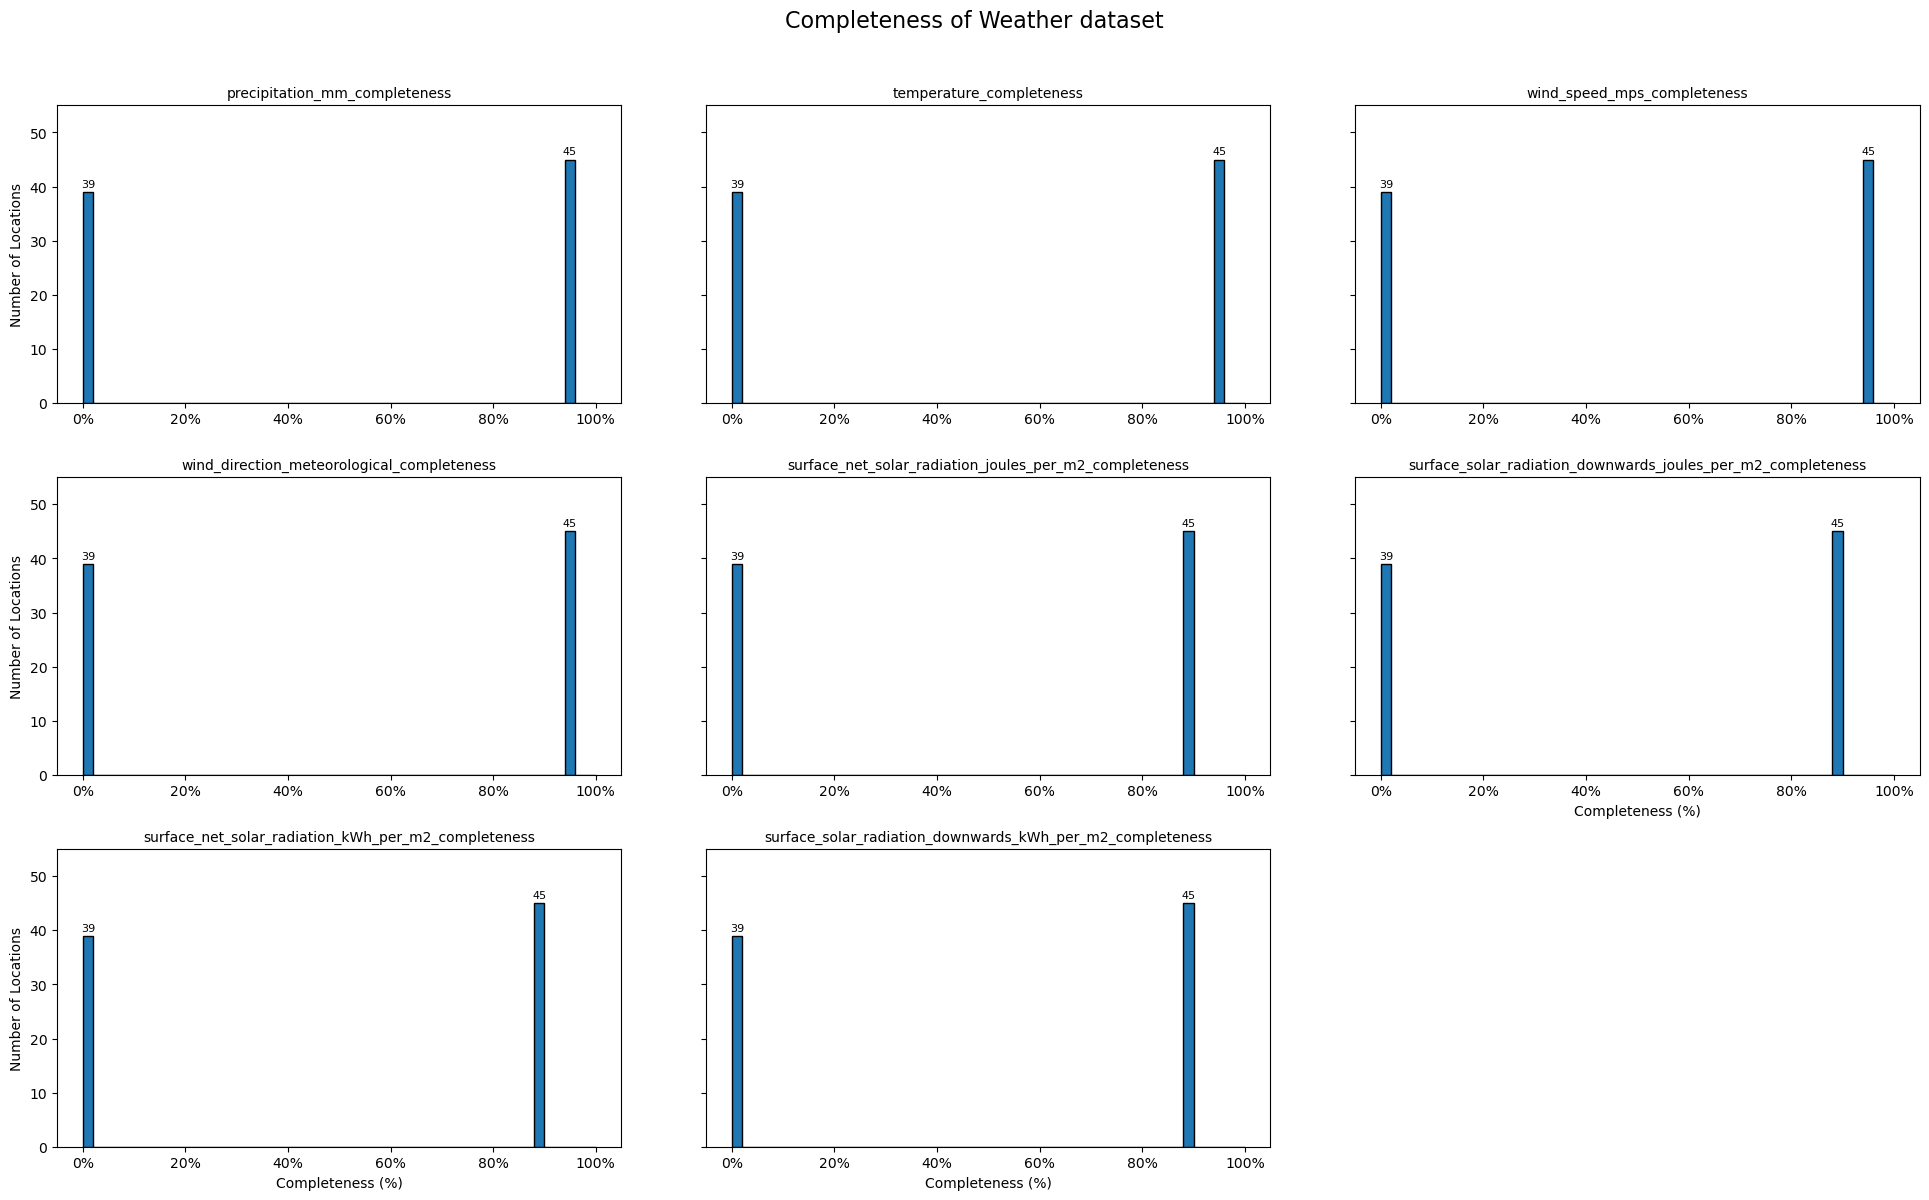

In [32]:
# Plot
g = sns.FacetGrid(
    plot_df,
    col="column",
    col_wrap=3,
    height=4.0,
    aspect=1.6,
    sharex=True,
    sharey=True,
    despine=False
)

g.map_dataframe(hist_with_counts)

# Formatting
g.set_titles("{col_name}")
g.set_axis_labels("Completeness (%)", "Number of Locations")
for ax in g.axes.flatten():
    ax.set_xlim(-5, 105)
    ax.set_ylim(0, 55)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
    ax.xaxis.set_major_formatter(ticker.PercentFormatter())
    ax.tick_params(labelbottom=True)

plt.subplots_adjust(top=0.9, hspace=0.25, wspace=0.15)
g.fig.suptitle("Completeness of Weather dataset", fontsize=16)
plt.show()

### Data Transformation (3)


In [33]:
# using the locations with 0% completeness to filter out these locations from the weather data
zero_avg_locations = completeness_report.filter(
    pl.col(name="avg_completeness") == 0
).select("land_latitude", "land_longitude")

weather_data_pldf_no_null_locations = weather_data_pldf_trans_2.join(
    zero_avg_locations.select(grouping_cols),
    on=grouping_cols,
    how="anti"
)

In [34]:
# Verify that the locations with 0% completeness have been removed
completeness_report_no_null = weather_data_pldf_no_null_locations.group_by(grouping_cols).agg(
    [
        pl.len().alias("total_rows"),
        *[pl.col(col).is_not_null().sum().alias(f"{col}_non_null") for col in columns_to_check]
    ]
)
# Display the updated completeness report
display(completeness_report_no_null.head(3))
display(completeness_report_no_null.describe())

land_latitude,land_longitude,total_rows,precipitation_mm_non_null,temperature_non_null,wind_speed_mps_non_null,wind_direction_meteorological_non_null,surface_net_solar_radiation_joules_per_m2_non_null,surface_solar_radiation_downwards_joules_per_m2_non_null,surface_net_solar_radiation_kWh_per_m2_non_null,surface_solar_radiation_downwards_kWh_per_m2_non_null
f64,f64,u32,u32,u32,u32,u32,u32,u32,u32,u32
28.6,77.14,47496,45473,45473,45473,45473,41999,41999,41999,41999
28.4,76.84,47496,45473,45473,45473,45473,41999,41999,41999,41999
28.7,77.04,47496,45473,45473,45473,45473,41999,41999,41999,41999


statistic,land_latitude,land_longitude,total_rows,precipitation_mm_non_null,temperature_non_null,wind_speed_mps_non_null,wind_direction_meteorological_non_null,surface_net_solar_radiation_joules_per_m2_non_null,surface_solar_radiation_downwards_joules_per_m2_non_null,surface_net_solar_radiation_kWh_per_m2_non_null,surface_solar_radiation_downwards_kWh_per_m2_non_null
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",25.393333,75.701111,47496.0,45473.0,45473.0,45473.0,45473.0,41998.955556,41998.977778,41998.955556,41998.977778
"""std""",4.58988,1.991707,0.0,0.0,0.0,0.0,0.0,0.208409,0.149071,0.208409,0.149071
"""min""",18.5,72.77,47496.0,45473.0,45473.0,45473.0,45473.0,41998.0,41998.0,41998.0,41998.0
"""25%""",19.2,72.97,47496.0,45473.0,45473.0,45473.0,45473.0,41999.0,41999.0,41999.0,41999.0
"""50%""",28.5,76.94,47496.0,45473.0,45473.0,45473.0,45473.0,41999.0,41999.0,41999.0,41999.0
"""75%""",28.7,77.14,47496.0,45473.0,45473.0,45473.0,45473.0,41999.0,41999.0,41999.0,41999.0
"""max""",28.8,77.34,47496.0,45473.0,45473.0,45473.0,45473.0,41999.0,41999.0,41999.0,41999.0


In [35]:
display(weather_data_pldf_no_null_locations.sample(n=8, with_replacement=False))

timestamp,temperature,city,surface_net_solar_radiation_joules_per_m2,surface_solar_radiation_downwards_joules_per_m2,surface_net_solar_radiation_kWh_per_m2,surface_solar_radiation_downwards_kWh_per_m2,precipitation_mm,wind_speed_mps,wind_direction_meteorological,land_longitude,land_latitude
"datetime[μs, UTC]",f64,cat,f64,f64,f64,f64,f64,f32,f32,f64,f64
2022-11-06 00:00:00 UTC,null,"""delhi""",null,null,null,null,null,null,null,77.14,28.7
2024-07-19 09:00:00 UTC,34.120514,"""delhi""",1.2234387e7,1.5529809e7,3.3984e6,4.3138e6,0.409899,2.244403,109.216675,76.94,28.5
2020-08-21 05:00:00 UTC,29.900604,"""delhi""",3.83523e6,4944837.5,1.0653e6,1.3736e6,0.009285,5.073352,112.909973,76.94,28.4
2023-03-10 06:00:00 UTC,32.246765,"""mumbai""",null,null,null,null,0.0,2.701482,44.144623,72.97,18.6
2024-05-05 23:00:00 UTC,25.772583,"""delhi""",2.3256638e7,2.7830418e7,6.4602e6,7.7307e6,0.0,2.539384,320.983643,77.24,28.6
2023-07-16 19:00:00 UTC,27.908905,"""delhi""",1.1329187e7,1.4309e7,3.1470e6,3.9747e6,0.526269,1.156761,153.701721,76.84,28.5
2022-06-03 15:00:00 UTC,33.832733,"""delhi""",2.215717e7,2.7641942e7,6.1548e6,7.6783e6,0.000858,2.511501,47.116089,77.04,28.5
2024-07-30 18:00:00 UTC,25.951904,"""mumbai""",1.0377901e7,1.1815638e7,2.8828e6,3.2821e6,9.308009,6.940135,225.565918,72.97,19.0


In [36]:
weather_filepath_step4 = weather_filepath_step3.replace("_step3.parquet", "_step4.parquet")

try:
    weather_data_pldf_no_null_locations.write_parquet(file=weather_filepath_step4,
                                              statistics=True,
                                              compression="snappy")
    print(f"Data successfully written to {weather_filepath_step4}")
    weather_processing_filepaths.append(weather_filepath_step4)
except Exception as e:
    print(f"Error writing data to {weather_filepath_step4}: {e}")

Data successfully written to ../../data/hitachi/weather_20250714_1401_step4.parquet


### Data Completeness and Quality Checks (2)

In [37]:
completeness_report = compute_completeness(
    weather_data_pldf_no_null_locations,
    grouping_col=grouping_cols,
    columns_to_check=columns_to_check
)
plot_df = completeness_transform_long(
        completeness_report,
        grouping_col=grouping_cols,
        columns_to_check=columns_to_check
)

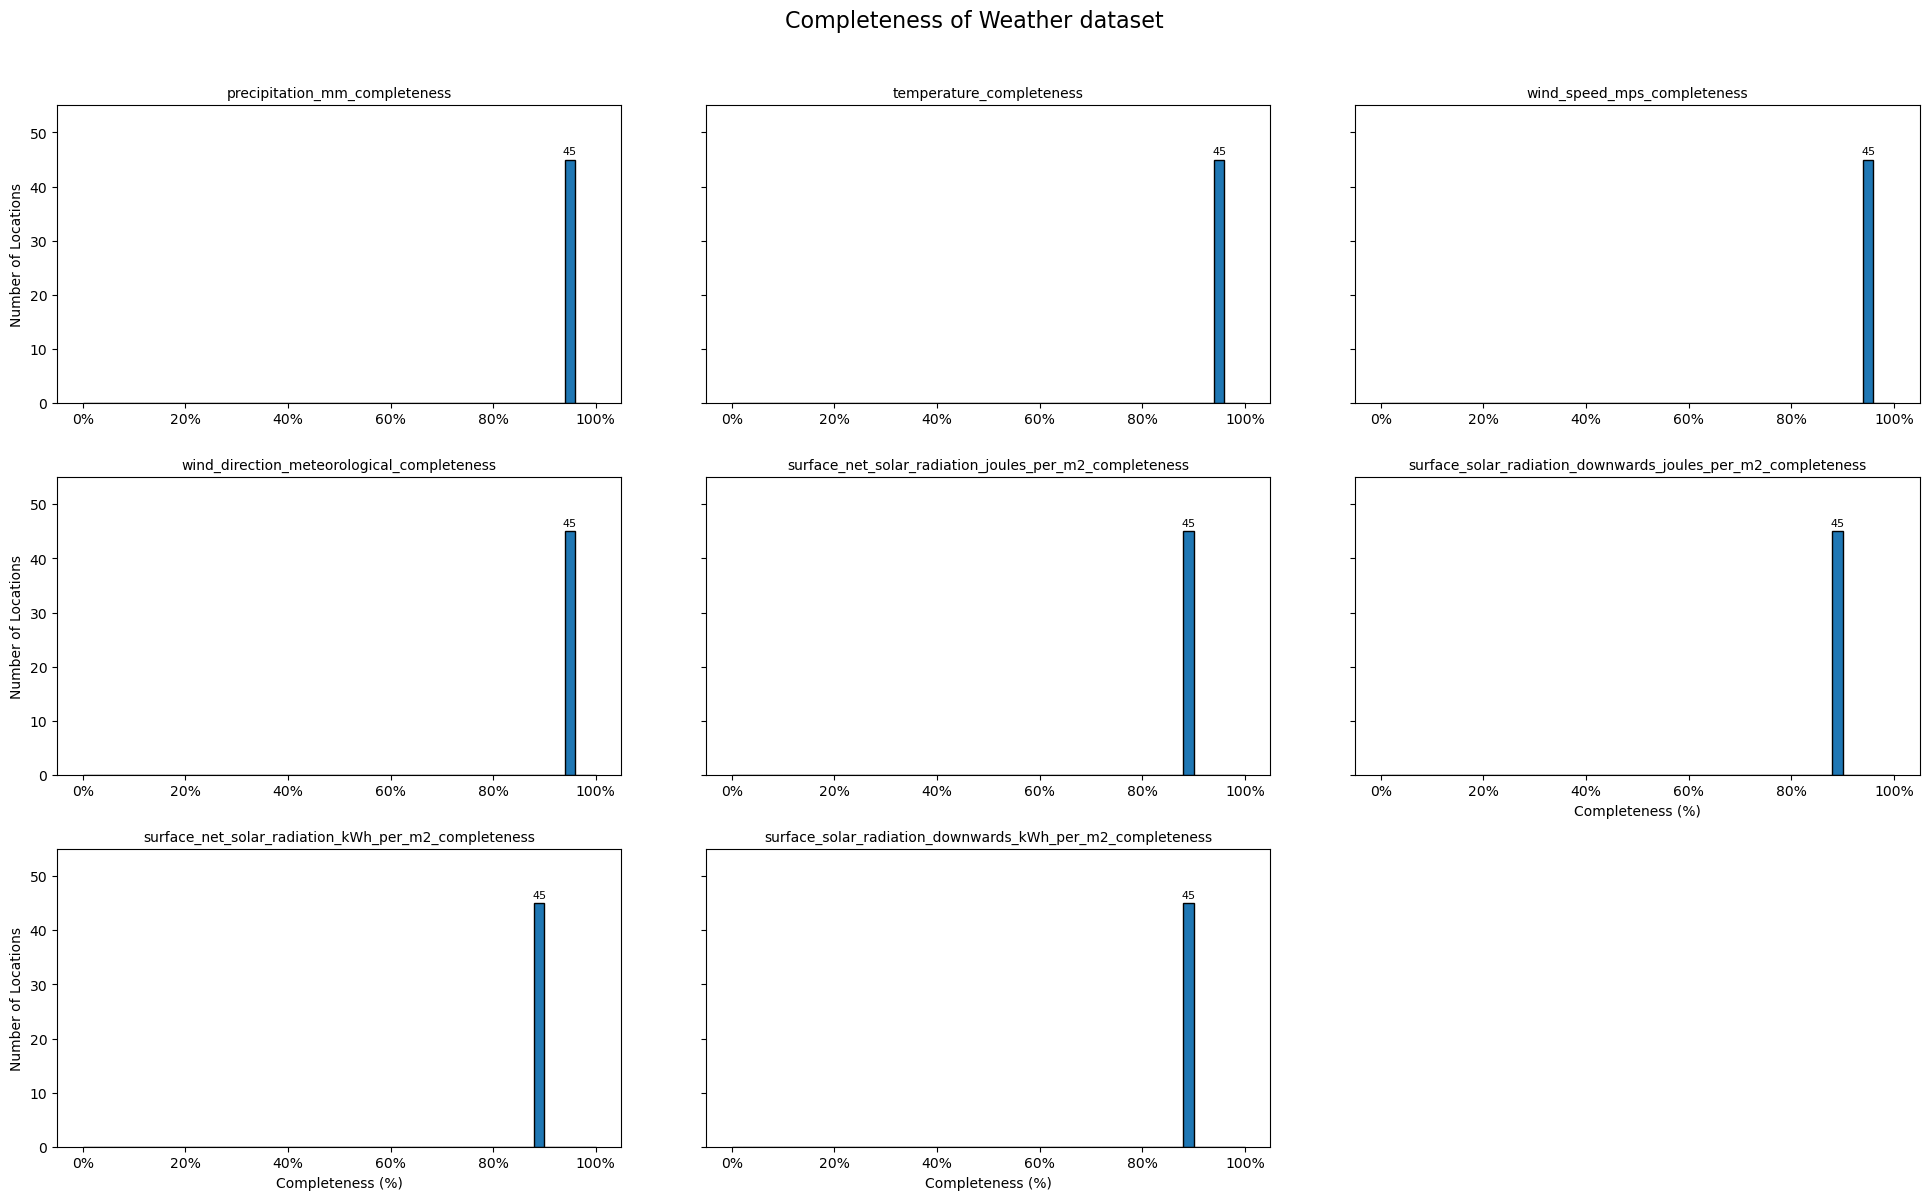

In [38]:
# Plot
g = sns.FacetGrid(
    plot_df,
    col="column",
    col_wrap=3,
    height=4.0,
    aspect=1.6,
    sharex=True,
    sharey=True,
    despine=False
)

g.map_dataframe(hist_with_counts)

# Formatting
g.set_titles("{col_name}")
g.set_axis_labels("Completeness (%)", "Number of Locations")
for ax in g.axes.flatten():
    ax.set_xlim(-5, 105)
    ax.set_ylim(0, 55)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
    ax.xaxis.set_major_formatter(ticker.PercentFormatter())
    ax.tick_params(labelbottom=True)

plt.subplots_adjust(top=0.9, hspace=0.25, wspace=0.15)
g.fig.suptitle("Completeness of Weather dataset", fontsize=16)
plt.show()

In [39]:
# remember that this variable has already been defined: 'columns_to_check'
all_locations = weather_data_pldf_no_null_locations.select(grouping_cols).unique()

result = all_locations

# Join each column's results
for col in columns_to_check:
    col_result = count_isolated_nulls(weather_data_pldf_no_null_locations, col, grouping_cols)
    result = result.join(
        col_result,
        on=grouping_cols,
        how="left"  # Keep all locations even if no isolated nulls
    )

# Fill null values with 0 (since no isolated nulls means count is 0)
result = result.fill_null(0)
display(result.sample(n=8, with_replacement=False))

land_latitude,land_longitude,precipitation_mm_isolated_nulls,temperature_isolated_nulls,wind_speed_mps_isolated_nulls,wind_direction_meteorological_isolated_nulls,surface_net_solar_radiation_joules_per_m2_isolated_nulls,surface_solar_radiation_downwards_joules_per_m2_isolated_nulls,surface_net_solar_radiation_kWh_per_m2_isolated_nulls,surface_solar_radiation_downwards_kWh_per_m2_isolated_nulls
f64,f64,u32,u32,u32,u32,u32,u32,u32,u32
28.4,77.04,1975,1975,1975,1975,1824,1824,1824,1824
28.5,77.14,1975,1975,1975,1975,1824,1824,1824,1824
28.8,76.84,1975,1975,1975,1975,1824,1824,1824,1824
19.1,72.97,1975,1975,1975,1975,1823,1824,1823,1824
28.7,76.94,1975,1975,1975,1975,1824,1824,1824,1824
28.8,77.04,1975,1975,1975,1975,1824,1824,1824,1824
28.4,77.24,1975,1975,1975,1975,1824,1825,1824,1825
19.3,72.87,1975,1975,1975,1975,1824,1824,1824,1824


In [40]:
# build a list of DataFrames, one per variable
stats_dfs = [
    analyze_null_patterns(weather_data_pldf_no_null_locations, col, grouping_cols)
    for col in columns_to_check
]

# reduce‑join them all together
final_stats = reduce(
    lambda left, right: left.join(
        right.select(grouping_cols + [c for c in right.columns if c not in grouping_cols]),
        on=grouping_cols,
        how="left"
    ),
    stats_dfs
).fill_null(0)

gap_cols = [f"{c}_gaps" for c in columns_to_check]

final_stats = final_stats.with_columns([
    # this sorts each List<Struct{gap_start, gap_end}> by gap_start (then gap_end if equal)
    pl.col(g).list.sort().alias(g)
    for g in gap_cols
])

display(final_stats.sample(n=8, with_replacement=False))

land_latitude,land_longitude,precipitation_mm_total_nulls,precipitation_mm_isolated_nulls,precipitation_mm_gaps,temperature_total_nulls,temperature_isolated_nulls,temperature_gaps,wind_speed_mps_total_nulls,wind_speed_mps_isolated_nulls,wind_speed_mps_gaps,wind_direction_meteorological_total_nulls,wind_direction_meteorological_isolated_nulls,wind_direction_meteorological_gaps,surface_net_solar_radiation_joules_per_m2_total_nulls,surface_net_solar_radiation_joules_per_m2_isolated_nulls,surface_net_solar_radiation_joules_per_m2_gaps,surface_solar_radiation_downwards_joules_per_m2_total_nulls,surface_solar_radiation_downwards_joules_per_m2_isolated_nulls,surface_solar_radiation_downwards_joules_per_m2_gaps,surface_net_solar_radiation_kWh_per_m2_total_nulls,surface_net_solar_radiation_kWh_per_m2_isolated_nulls,surface_net_solar_radiation_kWh_per_m2_gaps,surface_solar_radiation_downwards_kWh_per_m2_total_nulls,surface_solar_radiation_downwards_kWh_per_m2_isolated_nulls,surface_solar_radiation_downwards_kWh_per_m2_gaps
f64,f64,u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]]
19.2,72.97,2023,1975,"[{2019-12-31 02:00:00 UTC,2019-12-31 23:00:00 UTC}, {2022-10-31 00:00:00 UTC,2022-10-31 23:00:00 UTC}]",2023,1975,"[{2019-12-31 02:00:00 UTC,2019-12-31 23:00:00 UTC}, {2022-10-31 00:00:00 UTC,2022-10-31 23:00:00 UTC}]",2023,1975,"[{2019-12-31 02:00:00 UTC,2019-12-31 23:00:00 UTC}, {2022-10-31 00:00:00 UTC,2022-10-31 23:00:00 UTC}]",2023,1975,"[{2019-12-31 02:00:00 UTC,2019-12-31 23:00:00 UTC}, {2022-10-31 00:00:00 UTC,2022-10-31 23:00:00 UTC}]",5497,1824,"[{2019-12-31 02:00:00 UTC,2019-12-31 23:00:00 UTC}, {2022-10-31 00:00:00 UTC,2023-04-01 00:00:00 UTC}]",5497,1824,"[{2019-12-31 02:00:00 UTC,2019-12-31 23:00:00 UTC}, {2022-10-31 00:00:00 UTC,2023-04-01 00:00:00 UTC}]",5497,1824,"[{2019-12-31 02:00:00 UTC,2019-12-31 23:00:00 UTC}, {2022-10-31 00:00:00 UTC,2023-04-01 00:00:00 UTC}]",5497,1824,"[{2019-12-31 02:00:00 UTC,2019-12-31 23:00:00 UTC}, {2022-10-31 00:00:00 UTC,2023-04-01 00:00:00 UTC}]"
28.5,76.84,2023,1975,"[{2019-12-31 02:00:00 UTC,2019-12-31 23:00:00 UTC}, {2022-10-31 00:00:00 UTC,2022-10-31 23:00:00 UTC}]",2023,1975,"[{2019-12-31 02:00:00 UTC,2019-12-31 23:00:00 UTC}, {2022-10-31 00:00:00 UTC,2022-10-31 23:00:00 UTC}]",2023,1975,"[{2019-12-31 02:00:00 UTC,2019-12-31 23:00:00 UTC}, {2022-10-31 00:00:00 UTC,2022-10-31 23:00:00 UTC}]",2023,1975,"[{2019-12-31 02:00:00 UTC,2019-12-31 23:00:00 UTC}, {2022-10-31 00:00:00 UTC,2022-10-31 23:00:00 UTC}]",5497,1824,"[{2019-12-31 02:00:00 UTC,2019-12-31 23:00:00 UTC}, {2022-10-31 00:00:00 UTC,2023-04-01 00:00:00 UTC}]",5497,1824,"[{2019-12-31 02:00:00 UTC,2019-12-31 23:00:00 UTC}, {2022-10-31 00:00:00 UTC,2023-04-01 00:00:00 UTC}]",5497,1824,"[{2019-12-31 02:00:00 UTC,2019-12-31 23:00:00 UTC}, {2022-10-31 00:00:00 UTC,2023-04-01 00:00:00 UTC}]",5497,1824,"[{2019-12-31 02:00:00 UTC,2019-12-31 23:00:00 UTC}, {2022-10-31 00:00:00 UTC,2023-04-01 00:00:00 UTC}]"
19.3,72.87,2023,1975,"[{2019-12-31 02:00:00 UTC,2019-12-31 23:00:00 UTC}, {2022-10-31 00:00:00 UTC,2022-10-31 23:00:00 UTC}]",2023,1975,"[{2019-12-31 02:00:00 UTC,2019-12-31 23:00:00 UTC}, {2022-10-31 00:00:00 UTC,2022-10-31 23:00:00 UTC}]",2023,1975,"[{2019-12-31 02:00:00 UTC,2019-12-31 23:00:00 UTC}, {2022-10-31 00:00:00 UTC,2022-10-31 23:00:00 UTC}]",2023,1975,"[{2019-12-31 02:00:00 UTC,2019-12-31 23:00:00 UTC}, {2022-10-31 00:00:00 UTC,2022-10-31 23:00:00 UTC}]",5497,1824,"[{2019-12-31 02:00:00 UTC,2019-12-31 23:00:00 UTC}, {2022-10-31 00:00:00 UTC,2023-04-01 00:00:00 UTC}]",5497,1824,"[{2019-12-31 02:00:00 UTC,2019-12-31 23:00:00 UTC}, {2022-10-31 00:00:00 UTC,2023-04-01 00:00:00 UTC}]",5497,1824,"[{2019-12-31 02:00:00 UTC,2019-12-31 23:00:00 UTC}, {2022-10-31 00:00:00 UTC,2023-04-01 00:00:00 UTC}]",5497,1824,"[{2019-12-31 02:00:00 UTC,2019-12-31 23:00:00 UTC}, {2022-10-31 00:00:00 UTC,2023-

Based on the sample above we see a few different patterns that we assume hold true to the rest of the dataset

1. There are a significant amount of isolated nulls
    * These can likely be solved through a simple imputation of the mean values surrounding them

2. The date of 2019-12-31 is causing problems for every single variable
    * We can probably drop this date as it is outside our analysis range anyway.

3. All variables have issues (nulls) on the date 2022-10-31 into 2022-11-01.
    * For wind_speed, wind_direction, temperature, and precipitation_mm, the nulls begin at 2022-10-31 05:30:00 IST, but end relatively soon after at 2022-11-01 04:30:00 IST. We should be able to fill this gap by imputing data from the surrounding days.

    * For surface_net_solar_radiation_kwh and surface_solar_radiation_downwards_kwh, the nulls also begin at 2022-10-31 05:30:00 IST, but last until 2023-04-01 05:30:00 IST. This is a significant gap that will need to be addressed.

### Cleanup

In [41]:
weather_data_pldf_no_null_locations.schema


Schema([('timestamp', Datetime(time_unit='us', time_zone='UTC')),
        ('temperature', Float64),
        ('city', Categorical(ordering='physical')),
        ('surface_net_solar_radiation_joules_per_m2', Float64),
        ('surface_solar_radiation_downwards_joules_per_m2', Float64),
        ('surface_net_solar_radiation_kWh_per_m2', Float64),
        ('surface_solar_radiation_downwards_kWh_per_m2', Float64),
        ('precipitation_mm', Float64),
        ('wind_speed_mps', Float32),
        ('wind_direction_meteorological', Float32),
        ('land_longitude', Float64),
        ('land_latitude', Float64)])

In [42]:
# Reordering columns for better readability
weather_data_pldf_no_null_locations = weather_data_pldf_no_null_locations.select([
    "timestamp",
    "land_latitude",
    "land_longitude",
    "city",
    "precipitation_mm",
    "temperature",
    "wind_speed_mps",
    "wind_direction_meteorological",
    "surface_net_solar_radiation_kWh_per_m2",
    "surface_solar_radiation_downwards_kWh_per_m2",
    "surface_net_solar_radiation_joules_per_m2",
    "surface_solar_radiation_downwards_joules_per_m2",
])


In [43]:
weather_data_pldf_no_null_locations.schema

Schema([('timestamp', Datetime(time_unit='us', time_zone='UTC')),
        ('land_latitude', Float64),
        ('land_longitude', Float64),
        ('city', Categorical(ordering='physical')),
        ('precipitation_mm', Float64),
        ('temperature', Float64),
        ('wind_speed_mps', Float32),
        ('wind_direction_meteorological', Float32),
        ('surface_net_solar_radiation_kWh_per_m2', Float64),
        ('surface_solar_radiation_downwards_kWh_per_m2', Float64),
        ('surface_net_solar_radiation_joules_per_m2', Float64),
        ('surface_solar_radiation_downwards_joules_per_m2', Float64)])

In [44]:
# Resave the file in the new column order
weather_filepath_final = weather_filepath_step4.replace("_step4.parquet", "_processed.parquet")
try:
    weather_data_pldf_no_null_locations.write_parquet(weather_filepath_final)
    print(f"Data successfully written to {weather_filepath_final}")
except Exception as e:
    print(f"Error writing data to {weather_filepath_final}: {e}")

Data successfully written to ../../data/hitachi/weather_20250714_1401_processed.parquet


In [45]:
# Remove the temporary files created during processing
for filepath in weather_processing_filepaths:
    try:
        os.remove(filepath)
        print(f"Temporary file {filepath} removed successfully.")
    except Exception as e:
        print(f"Error removing temporary file {filepath}: {e}")
print("\n" + "-" * 120)
print("Processing complete. All temporary files removed.")
print("-" * 120)
print("Final processed weather data saved at:", weather_filepath_final)
print("-" * 120)
print("End of processing ERA5 Land data notebook.")

Temporary file ../../data/hitachi/weather_20250714_1401_step1.parquet removed successfully.
Temporary file ../../data/hitachi/weather_20250714_1401_step2.parquet removed successfully.
Temporary file ../../data/hitachi/weather_20250714_1401_step3.parquet removed successfully.
Temporary file ../../data/hitachi/weather_20250714_1401_step4.parquet removed successfully.

------------------------------------------------------------------------------------------------------------------------
Processing complete. All temporary files removed.
------------------------------------------------------------------------------------------------------------------------
Final processed weather data saved at: ../../data/hitachi/weather_20250714_1401_processed.parquet
------------------------------------------------------------------------------------------------------------------------
End of processing ERA5 Land data notebook.


### Summary

**Overview**

This notebook analyzes and processes ERA5-Land weather data from the Hitachi database, preparing it for use in energy demand and carbon emissions modeling. The data provides hourly weather measurements at multiple locations in Delhi and Mumbai from 2019 to 2025.


**Key Findings**
- **Data Structure**
  - Original Format: Weather data contains hourly readings with 84 unique locations (30 in Delhi, 54 in Mumbai)
  - Time Range: From 2019-12-31 01:00 to 2025-06-01 00:00 (UTC)
  - Variables: Wind speed, wind direction, temperature, precipitation, and two solar radiation measures
  - Geographic Coverage: Each location represents approximately a 9km grid cell

**Data Quality Issues**
- Missing Locations: Of the 84 locations, 39 have completely empty data (0% completeness)
- Temporal Gaps: Common patterns of missing data identified:
  - Midnight (00:00) readings are frequently missing
  - 2022-10-31 has widespread gaps across all variables
  - Solar radiation fields have an extended gap from 2022-10-31 to 2023-04-01
- Data Format Issues: Several variables require unit conversion and deaccumulation
- Wind direction needed correction (180° shift) to align with meteorological conventions



**Transformations Performed**
- Data Type Conversion:
    - Standardized column types (Float32/Float64 for measurements)
    - Converted categorical values to appropriate types
- Unit Standardization:
    - Wind speed: Converted mph to m/s
    - Precipitation: Converted meters to millimeters
    - Solar radiation: Converted joules/m² to kWh/m²
    - Wind direction: Adjusted mathematical to meteorological convention (180° shift)
- Coordinate Processing:
    - Converted WKB location format to explicit latitude and longitude coordinates
    - Retained UTC time zone for consistency with other datasets
- Null Handling:
    - Identified and quantified isolated nulls vs. extended gaps
    - Filtered out locations with 0% completeness
    - Created patterns analysis for future gap-filling operations


**Next Steps:**
* The ERA5-Land data will require special handling for accumulated variables (precipitation, solar radiation)
* Time Zone Alignment: Convert to IST (UTC+5:30) when joining with grid or meter data
* Downsample to half-hourly intervals for alignment with meter readings dataset
